# Trabajo Practico 4

In [2]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import scipy 
import numpy as np
import random as rd
import nltk
import pickle
import sklearn
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import datetime
from tqdm import tqdm

%matplotlib inline
nltk.download('stopwords')

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igna-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
tweets = pd.read_csv('train_EN.csv')

In [4]:
train = tweets.iloc[:,1:3]
train.loc[857:890,:]
train.dropna(inplace =True)

In [5]:
train['tweet'] = train['tweet'].str.lower()
train['tweet'] = train['tweet'].astype(str)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['tweet'], train['sarcastic'], test_size=0.2, train_size=0.8, random_state=1999)

In [7]:
X_test = X_test.dropna()
y_test = y_test.dropna()

In [8]:
index = []
for indice in X_test.index:
    if indice in y_test.index:
        index.append(indice)
indices = list(set(y_test.index) & set(index))
X_test = X_test[X_test.index.isin(indices)]

In [9]:
stop_words = set(nltk.corpus.stopwords.words('english'))

count_vec = sklearn.feature_extraction.text.CountVectorizer(stop_words=stop_words)
count_vec.fit(X_train.values.tolist())
df_count_vec = count_vec.transform(X_train.values.tolist())

In [10]:
tfidf_transformer = sklearn.feature_extraction.text.TfidfTransformer()
tfidf_transformer.fit(df_count_vec)
X_train_transformed = tfidf_transformer.transform(df_count_vec)

In [11]:
X_train_transformed.shape

(2773, 8922)

In [12]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200, random_state=42)
X_train_transformed_reduced = svd.fit_transform(X_train_transformed) 


In [13]:
X_train_transformed_reduced.shape

(2773, 200)

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric = "cosine" ).fit_transform(X_train_transformed_reduced)

<AxesSubplot:>

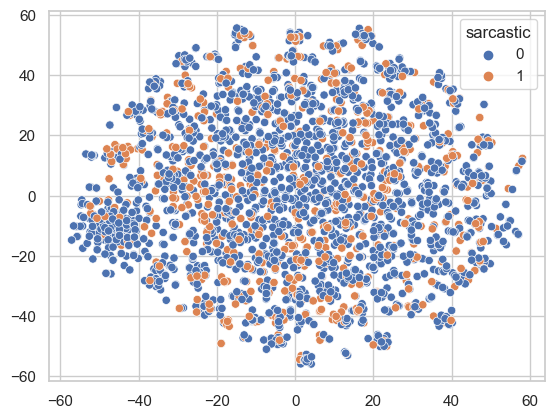

In [15]:
sns.scatterplot(x = tsne[:,0], y = tsne[:,1], hue= y_train)

In [16]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train_transformed_reduced, y_train)

GaussianNB()

In [17]:
df_count_vec = count_vec.transform(X_test.values.tolist())
X_test_transformed = tfidf_transformer.transform(df_count_vec)
X_test_transformed_reduced = svd.transform(X_test_transformed) 

In [18]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, clf.predict(X_test_transformed_reduced)))
roc_auc_score(y_test, clf.predict(X_test_transformed_reduced))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       532
           1       0.32      0.25      0.28       162

    accuracy                           0.70       694
   macro avg       0.55      0.54      0.55       694
weighted avg       0.68      0.70      0.69       694



0.5445094217024041

In [19]:
exp = pd.concat([X_test,y_test], axis =1)

In [20]:
exp["predict"] =  clf.predict(X_test_transformed_reduced)

In [21]:
exp = exp.loc[exp['predict'] != exp['sarcastic']]

In [22]:
pd.options.display.max_colwidth = None
exp

,tweet,sarcastic,predict
1562,trying to pavlov dog my way out of chronic dehydration :/ every 8oz i get a little treat,0,1
2091,my mum seriously out here trying to convince me the queen has gone part time,0,1
2147,man savathuns design is so fuckin creepy i love her.,0,1
2837,@fishy_lo @officialplt_cs @officialplt why type of lube did you order? i may have extra in my detached garage,0,1
2205,i have such an obsession with white shoes but can’t keep them clean. someone help me :(,0,1
...,...,...,...
437,"head is pounding, spent £25 on ubers last night and i have a 3000 word report to write :) yippee x",1,0
2288,80% of #littlehouseontheprairie episodes involve laura befriending weird old men.,0,1
548,good morning september... hello tonsillitis :(,1,0
232,it’s been 20 hours and i want another chai latte with pumpkin cold foam i can’t afford this!,1,0


In [23]:
exp.loc[(exp['predict'] == 1) & (exp['sarcastic'] == 0)].sample(10)

,tweet,sarcastic,predict
1233,"if u watch the game at my house &amp; u talk during cal's halftime interviews, my dad will frantically shush u and say ""god is talking!""",0,1
3056,"don’t let anyone ruin your day, it’s your day. ruin it yourself",0,1
2287,how about trump taking credit for freeing alice johnson when we all know it was @kimkardashian that facilitated that. #kkw2022,0,1
2442,"love is so fucking weird.\r\n\r\nlove made me want to die a thousand times over in the past, but now love makes me want to re-clean the toilet because i blew it up after she cleaned it.\r\n\r\ni've never publicly said this, but my previous encounters with love were ponds, this one is a sea.",0,1
2288,80% of #littlehouseontheprairie episodes involve laura befriending weird old men.,0,1
1209,lol i actually realized that i’ve justified not working out for the past three months by telling myself that my hair was too short to fit in a ponytail.,0,1
1348,1 in 1000 men will develop breast cancer in their lifetime. it has a higher mortality rate for men because they haven’t been taught the early signs and that they can get it too!! breast cancer awareness isn’t just for women!!,0,1
2666,is adulthood really just doing lots of things then feeling absolutely exhausted for the rest of the day?,0,1
3059,how can a person look at lizzo and not think she’s hot it makes no sense,0,1
3246,it'll all be okay in the end 👍,0,1
